[IPython Notebook](koi126.ipynb) |  [Python Script](koi126.py)

KOI-126
============================

**NOTE: triples are not supported yet - and this clearly shows why**

Setup
-----------------------------

As always, let's do imports and initialize a logger and a new bundle.  See [Building a System](../tutorials/building_a_system.html) for more details.

In [23]:
from IPython.display import Image

In [24]:
%matplotlib inline

In [25]:
import phoebe
from phoebe import u # units
import numpy as np
import matplotlib.pyplot as plt

logger = phoebe.logger(clevel='INFO')

b = phoebe.Bundle.default_triple(inner_as_primary=False, starC='starA', starA='starB', starB='starC')

We override the default labels to try to mimic the (A, (B, C)) notation used within [Carter et al 2011](http://adsabs.harvard.edu/abs/2011Sci...331..562C).

In [26]:
print b.hierarchy


    orbit:outer 
    
        star:starA 
        orbit:inner 
        
            star:starB 
            star:starC
        
    



System Parameters
---------------------------

Now we build the system to match all the published parameters found in Table 1 of [Carter et al 2011](http://adsabs.harvard.edu/abs/2011Sci...331..562C) (shown below).

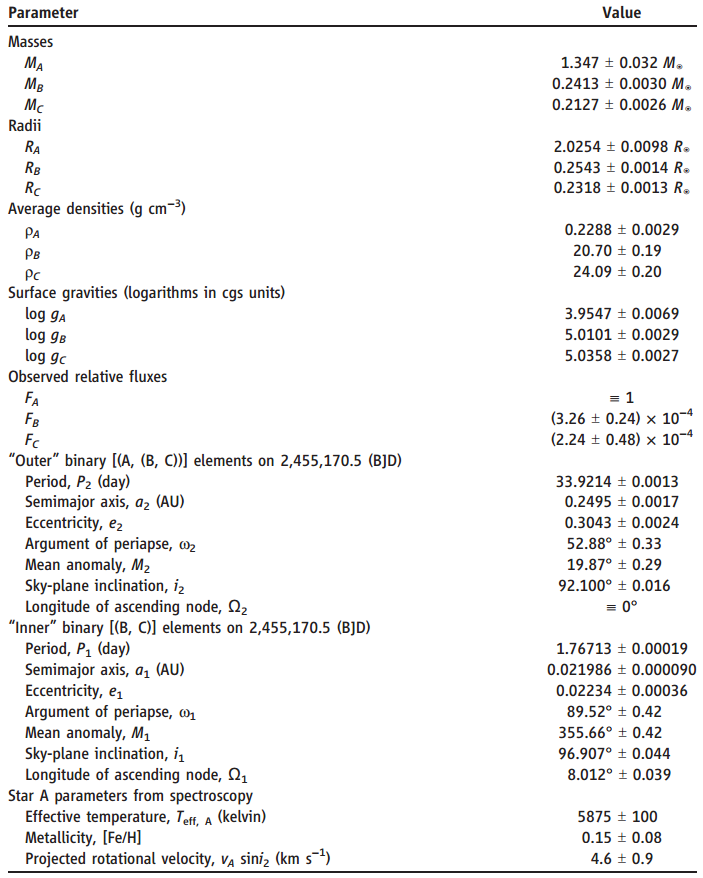

In [27]:
Image(filename='koi126_carter+2011table1.png')

In order to provide mean anomaly, we need to flip a few constraints.  For more information see the [constraint tutorial](../tutorials/constraints)

In [28]:
b.flip_constraint('t0_perpass@inner', solve_for='t0_supconj')
b.flip_constraint('mean_anom@inner', solve_for='t0_perpass')

<ConstraintParameter: {t0_perpass@inner@component} = {t0@system} - (({mean_anom@inner@component} * {period@inner@component}) / 6.283185307179586231995926937088) => -0.249999987778 d>

In [29]:
b.flip_constraint('t0_perpass@outer', solve_for='t0_supconj')
b.flip_constraint('mean_anom@outer', solve_for='t0_perpass')

<ConstraintParameter: {t0_perpass@outer@component} = {t0@system} - (({mean_anom@outer@component} * {period@outer@component}) / 6.283185307179586231995926937088) => -2.49999987778 d>

In [30]:
b.set_value('dict_filter@setting', {'context': 'component'})

In [31]:
b['rpole@starA'] = 2.0254 * u.solRad
b['rpole@starB'] = 0.2543 * u.solRad
b['rpole@starC'] = 0.2318 * u.solRad

Note: we cannot directly set sma@outer as it is a constrained parameter and is ambiguous with other provided parameters.  Instead we'll check it later to make sure that the constraint results in the same value that is provided in Table 1.

In [32]:
b['period@outer'] = 33.9214 * u.d
# b['sma@outer'] = 0.2495 * u.AU # cannot set (constrained) - will check later
b['ecc@outer'] = 0.3043
b['per0@outer'] = 52.88 * u.deg

#mean_longitude = 19.87 * u.deg
#per0 = 52.88 * u.deg
#long_an = 0.0 * u.deg
#b['mean_anom@outer'] = mean_longitude - per0 - long_an

b['mean_anom@outer'] = 19.87 * u.deg

b['incl@outer'] = 92.1 * u.deg
b['long_an@outer'] = 0.0 * u.deg

In [33]:
b['period@inner'] = 1.76713 * u.d
b['sma@inner'] = 0.021986 * u.AU
b['ecc@inner'] = 0.02234
b['per0@inner'] = 89.52 * u.deg

#mean_longitude = 355.66 * u.deg
#per0 = 89.52 * u.deg
#long_an = 8.012 * u.deg
#b['mean_anom@outer'] = mean_longitude - per0 - long_an

b['mean_anom@outer'] = 355.66 * u.deg

b['incl@inner'] = 96.907 * u.deg
b['long_an@inner'] = 8.012 * u.deg

In [34]:
b['teff@starA'] = 5875 * u.K
b['abun@starA'] = 0.15
#b['period@starA'] = # vsini = 4.6

The paper only provides flux-ratios, which we'll set later.  But let's provide reasonable effective temperatures for starB and star C based on the provided masses.

In [35]:
b['teff@starB'] = 3000 * u.K
b['teff@starC'] = 3000 * u.K

PHOEBE doesn't (yet) allow you to flip all constraint in a triple so that you can provide all masses.  But we can obtain the same result by setting the appropriate mass ratios and allowing Kepler's third laws to compute the input masses.

In [36]:
massA = 1.347 * u.solMass
massB = 0.2413 * u.solMass
massC = 0.2127 * u.solMass
b['q@inner'] = massC/massB
b['q@outer'] = (massB+massC)/massA

In [37]:
print "mass of starA: {} ({})".format(b['mass@starA'].get_quantity(unit=u.solMass), massA)
print "mass of starB: {} ({})".format(b['mass@starB'].get_quantity(unit=u.solMass), massB)
print "mass of starC: {} ({})".format(b['mass@starC'].get_quantity(unit=u.solMass), massC)

mass of starA: 1.34703399546 solMass (1.347 solMass)
mass of starB: 0.241323712889 solMass (0.2413 solMass)
mass of starC: 0.212720902327 solMass (0.2127 solMass)


sma@outer was automatically determined by constraints to make sure the hierarchical orbit obeyed Kepler's third laws, but let's just check to make sure it matches the value in Table 1 (0.2495 AU)

In [38]:
print "outer sma: {} ({})".format(b['sma@outer'].get_quantity(unit=u.AU), 0.2495 * u.AU)

outer sma: 0.249512199023 AU (0.2495 AU)


In [39]:
b.set_value('dict_filter@setting', {})

In [40]:
b['t0@system'] = 2455170.5 - 2455000

In [41]:
b['t0_supconj@outer@component']

<Parameter: t0_supconj=140.485214567 d | keys: description, value, quantity, default_unit, limits, relevant_if, copy_for, timederiv>

In [42]:
b['t0_perpass@outer@component']

<Parameter: t0_perpass=136.987541322 d | keys: description, value, quantity, default_unit, limits, relevant_if, copy_for, timederiv>

Adding Datasets
----------------------

We want to reproduce the light curves in Figure 1 of [Carter et al 2011](http://adsabs.harvard.edu/abs/2011Sci...331..562C).  

The t0s used in each frame are listed in the figure caption, with the timespan ranging from t0-0.4 to t0+0.4 (for the top 8 panels).  We can reproduce these fairly easily by creating a separate light curve dataset for each frame.

NOTE: we'll set our times as BJD-2455000.

In [43]:
t0s = np.array([102.815, 136.716, 170.465, 204.267, 238.207, 271.751,
305.713, 339.496])
t0s += 2.4 # TODO: TESTING REMOVE

In [44]:
for t0 in t0s:
    times = np.linspace(t0-0.4, t0+0.4, 101)
    b.add_dataset('LC', time=times)
    b.add_dataset('ORB', time=times)
    b.add_dataset('MESH', time=[t0])

Since Table 1 provides relative fluxes, we'll decouple the passband luminosities and set them accordingly.  For more information on decoupling pblum, see the [pblum tutorial](../tutorials/pblum).

In [45]:
b.set_value_all('pblum@starA', 1 * (4 * np.pi))

In [46]:
b.set_value_all('pbscale@starB', 'pblum')
b.set_value_all('pblum@starB', 3.26E-4 * (4 * np.pi))

In [47]:
b.set_value_all('pbscale@starC', 'pblum')
b.set_value_all('pblum@starC', 2.24E-4 * (4 * np.pi))

Limb-darkening is discussed in the Online Material section of [Carter et al 2011](http://adsabs.harvard.edu/abs/2011Sci...331..562C): "The limb-darkening coefficients for
A were found to be u1 = 0.39±0.03 and u2 = 0.22±0.04. These values agree with theoretical
expectations for stars with temperatures, gravities and metallicities similar to those found for
KOI-126 A (0.3552 < u1 < 0.4009 and 0.2553 < u2 < 0.2869 for 5750K < Teff < 6000K,
log gA ≡ 4.0 and 0.10 <[M/H]< 0.20, S10). We investigated various limb-darkened profiles
for B and C according to the same model, however, any physically-valid choice of parameters
gave similar fit values within the quoted uncertainties."

In [48]:
b.set_value_all('ld_func', 'quadratic')
b.set_value_all('ld_coeffs@starA', [0.39, 0.22])
b.set_value_all('ld_coeffs@starB', [0.39, 0.22]) # NOTE: not actually reported in paper, so assume same as A
b.set_value_all('ld_coeffs@starC', [0.39, 0.22]) # NOTE: not actually reported in paper, so assume same as A

Running Compute
-----------------------

In [49]:
b.add_compute('photodynam', compute='pdcompute')

<ParameterSet: 3 parameters | qualifiers: orbiterror, stepsize, enabled>

In [50]:
b.run_compute('pdcompute', model='pd')

<ParameterSet: 184 parameters | methods: ORB, LC>

In [51]:
b.add_compute('phoebe', compute='phcompute', ltte=True)

<ParameterSet: 20 parameters | qualifiers: dynamics_method, gridsize, gr, rv_method, mesh_offset, integrator, atm, enabled, ltte, rv_grav, stepsize, etv_method, maxpoints, delta, etv_tol, store_mesh, distortion_method, eclipse_alg, mesh_method, lc_method>

In [52]:
b.run_compute('phcompute', dynamics_method='keplerian', distortion_method='roche', model='ph_kepl_roche')

<ParameterSet: 2128 parameters | methods: MESH, ORB, LC>

In [53]:
#b.run_compute('phcompute', dynamics_method='nbody', distortion_method='rotstar', model='ph_dynam_rotstar')

In [54]:
#b.run_compute('phcompute', dynamics_method='nbody', distortion_method='roche', model='ph_dynam_roche')

In [55]:
b.run_compute('phcompute', dynamics_method='bs', distortion_method='rotstar', model='ph_bs_rotstar')

<ParameterSet: 2128 parameters | methods: MESH, ORB, LC>

In [56]:
#b.run_compute('phcompute', dynamics_method='bs', distortion_method='roche', model='ph_bs_roche')

Plotting
-------------------------

We'll compare our models to [Carter et al 2011](http://adsabs.harvard.edu/abs/2011Sci...331..562C) Figure 1 (shown below).

In [57]:
def draw_lc_fig(model):
    fig, axs = plt.subplots(4,2, figsize=(9,10))
    lc_datasets = ['lc{:02d}'.format(i+1) for i in range(8)]
    for ax, ds in zip(axs.flatten(), lc_datasets):
        axs, artists = b.plot(dataset=ds, model=model, ax=ax)

In [58]:
def draw_mesh_orb_fig(model, draw_mesh=True):
    fig, axs = plt.subplots(4,2, figsize=(8,10))
    mesh_datasets = ['mesh{:02d}'.format(i+1) for i in range(8)]
    orb_datasets = ['orb{:02d}'.format(i+1) for i in range(8)]
    for ax, ds_mesh, ds_orb in zip(axs.flatten(), mesh_datasets, orb_datasets):
        if draw_mesh:
            axs, artists = b.plot(dataset=ds_mesh, model=model, ax=ax, y='y')
        axs, artists = b.plot(dataset=ds_orb, model=model, ax=ax, y='y')


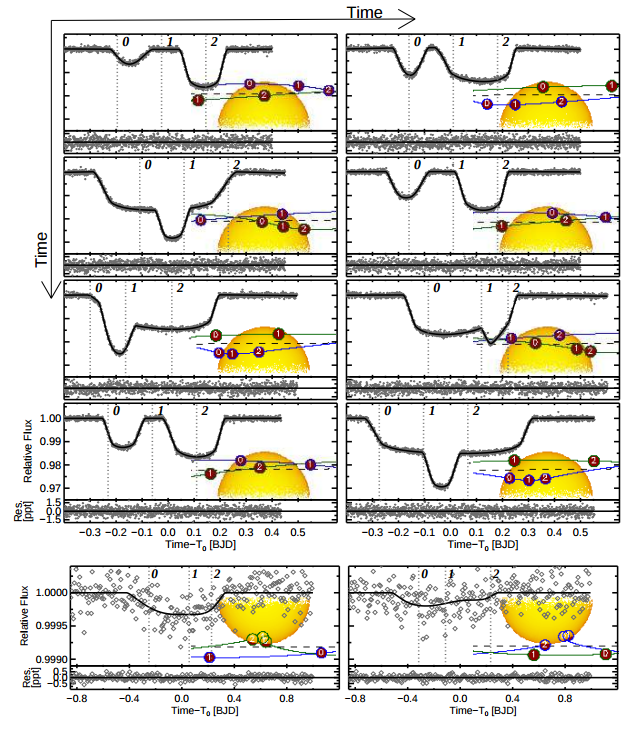

In [59]:
Image(filename='koi126_carter+2011fig1.png')

### Photodynam (code used in paper)

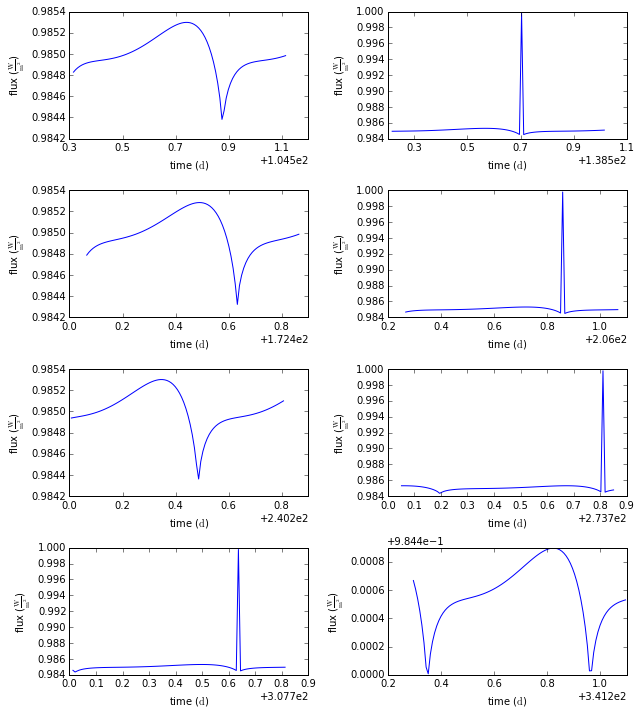

In [60]:
draw_lc_fig(model='pd')

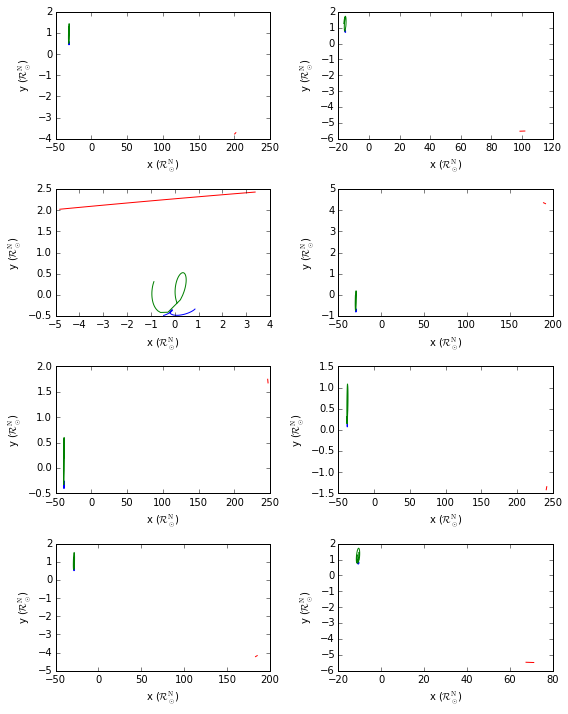

In [61]:
draw_mesh_orb_fig(model='pd', draw_mesh=False)

### PHOEBE with keplerian & roche

As mentioned in the paper, a strictly Keplerian model fails to model the full light curve.

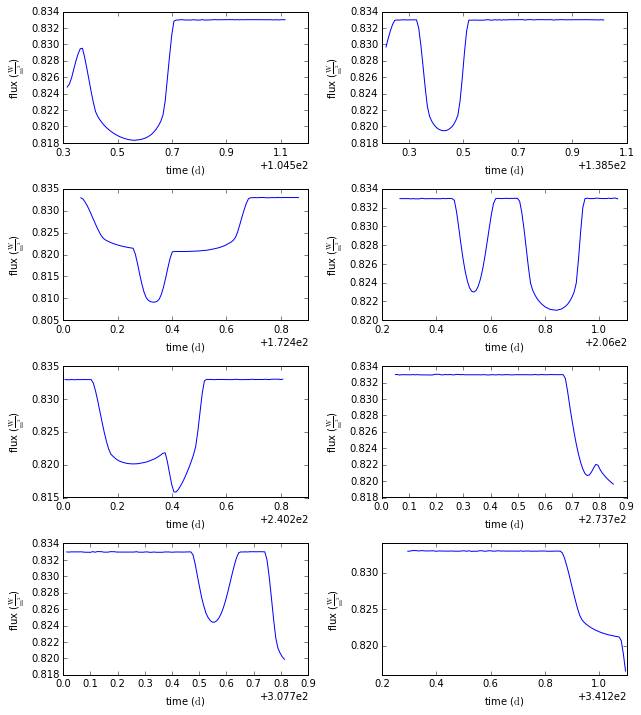

In [62]:
draw_lc_fig(model='ph_kepl_roche')

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


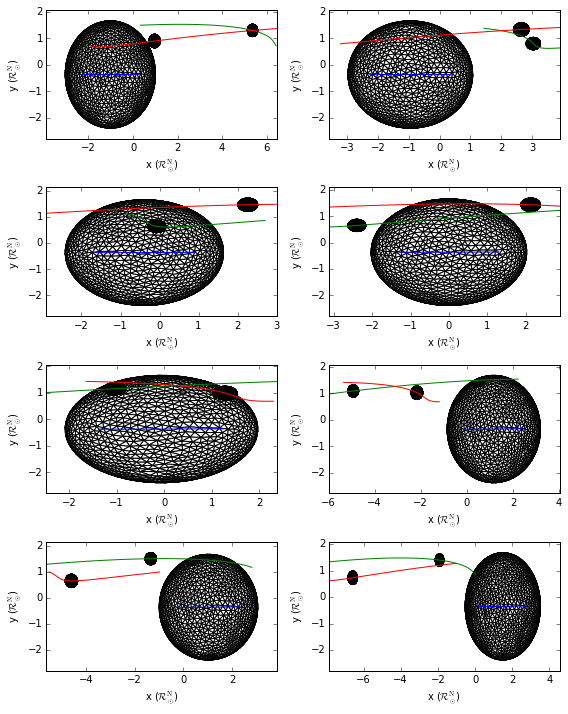

In [63]:
draw_mesh_orb_fig(model='ph_kepl_roche')

### PHOEBE with nbody & rotstar

In [64]:
#draw_lc_fig(model='ph_dynam_rotstar')

In [65]:
#draw_mesh_orb_fig(model='ph_dynam_rotstar', draw_mesh=False)

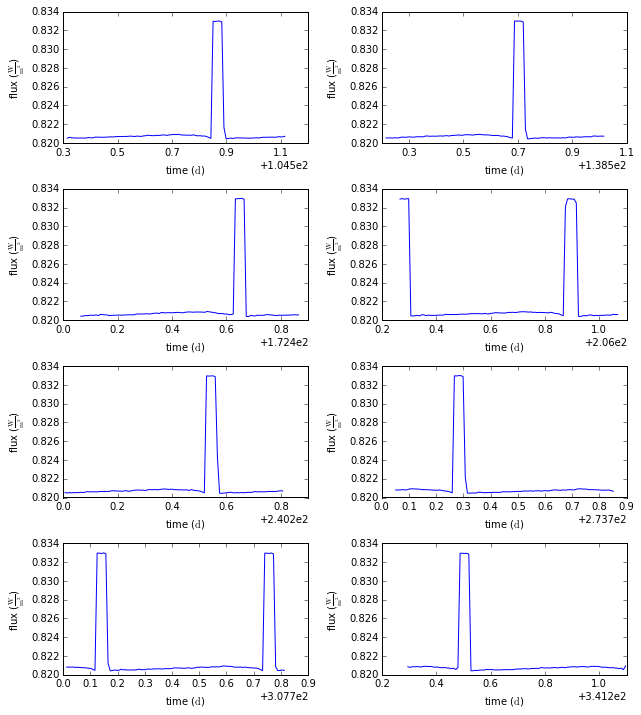

In [66]:
draw_lc_fig(model='ph_bs_rotstar')

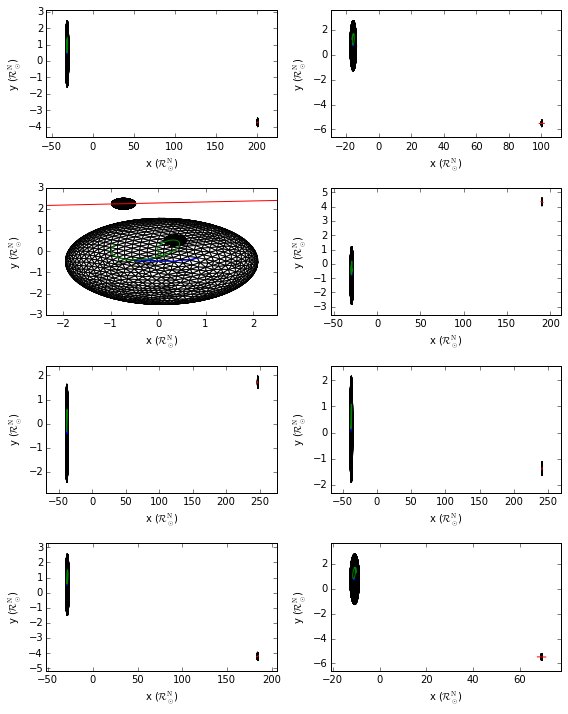

In [67]:
draw_mesh_orb_fig(model='ph_bs_rotstar')

### PHOEBE with nbody & roche

In [68]:
#draw_lc_fig(model='ph_dynam_roche')

In [69]:
#draw_mesh_fig(model='ph_dynam_roche')